In [22]:
import warnings

warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from tqdm import tqdm
import imgaug as ia
import imgaug.augmenters as iaa

% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import skimage
import os
from skimage.color import rgb2hsv
from skimage.color import rgb2gray
import scipy.misc
import imageio
import pandas as pd
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage import img_as_ubyte
import cv2
from scipy import ndimage
from sklearn.utils import resample

In [23]:
DATASET_PATH = r"./dataset/"
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
EPOCHS = 30
BATCH_SIZE = 32
SEED = 42
dataset_folders = []  # to keep main folder names
total = 0
print(f"There are {len(os.listdir(DATASET_PATH))} folder in dataset.")
for path in sorted(os.listdir(DATASET_PATH)):
    print(f"\t-There are {len(os.listdir(DATASET_PATH + path))} images in {path} folder.")
    total += len(os.listdir(DATASET_PATH + path))  # add element size of the current folder to total variable
    dataset_folders.append(DATASET_PATH + path)  # add current folder path to dataset_folders

# Create an empty dataframe
df = pd.DataFrame(0,
                  columns=['paths',
                           'class_label'],
                  index=range(total))
# store each image path in the dataframe
# class labels -> 0:Normal 1:Cataract 2:Glaucoma 3:RetinaDisease
i = 0
for p, path in enumerate(dataset_folders):  # main folders
    for sub_path in sorted(os.listdir(path)):  #images
        df.iloc[i, 0] = path + "/" + sub_path
        df.iloc[i, 1] = p
        i += 1
# Display some examples for the created DataFrame
# print(df.sample(frac=1, random_state=SEED).head(10))
train_df, test_df = train_test_split(df,
                                     test_size=0.2,
                                     random_state=SEED,
                                     stratify=df['class_label'])

There are 4 folder in dataset.
	-There are 300 images in 1_normal folder.
	-There are 100 images in 2_cataract folder.
	-There are 101 images in 2_glaucoma folder.
	-There are 100 images in 3_retina_disease folder.


In [24]:
#Cropping image to avoid from unnecessary black areas
def deleteBlackAreas(filename):
    image_size = (IMAGE_WIDTH, IMAGE_HEIGHT)
    img = cv2.imread(filename)  #read image from file
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # convert to grayscale
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)  # turn it into a binary image
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # find contours
    if len(contours) != 0:
        #find the biggest area
        cnt = max(contours, key=cv2.contourArea)

        #find the bounding rect
        x, y, w, h = cv2.boundingRect(cnt)

        crop = img[y:y + h, x:x + w]  # crop image
        crop1 = cv2.cvtColor(cv2.resize(crop, image_size, interpolation=cv2.INTER_AREA),
                             cv2.COLOR_BGR2RGB)  # resize to image_size and change color space from BGR to RGB for matplotlib
        return crop1
    else:
        return cv2.cvtColor(cv2.resize(img, image_size, interpolation=cv2.INTER_AREA), cv2.COLOR_BGR2RGB)

In [25]:
def create_dataset(df):
    # Creating dataset
    images = []
    labels = []
    index = 0
    for path in tqdm(df['paths']):
        #According to parameter, we apply some preprocesses here. default=0
        img = deleteBlackAreas(path)  #deleting black areas. Initial preprocess
        label = [0, 0, 0, 0]
        label[df.iloc[index]["class_label"]] += 1
        index += 1
        images.append(img)
        labels.append(label)
    images = np.array(images, dtype='uint8')
    labels = np.array(labels)
    return augmentation(images, labels)


def augmentation(images, labels):
    ia.seed(42)
    crop = iaa.Sequential([
        iaa.Sometimes(
            0.5,
            iaa.GaussianBlur(sigma=(0, 0.25))
        ),
        iaa.Crop(percent=(0, 0.15))
    ])

    contrast = iaa.Sequential([
        iaa.Sometimes(
            0.5,
            iaa.GaussianBlur(sigma=(0, 0.25))
        ),
        iaa.LinearContrast((0.75, 1.5)),
    ])

    mix = iaa.Sequential([
        iaa.Sometimes(
            0.5,
            iaa.Crop(percent=(0, 0.1)),  # random crops
        ),
        iaa.Sometimes(
            0.5,
            iaa.GaussianBlur(sigma=(0, 0.25))
        ),
        iaa.Sometimes(
            0.5,
            iaa.LinearContrast((0.75, 1.5)),
        ),
        iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            #translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=(-25, 25),
            shear=(-4, 4)
        )
    ], random_order=True)  # apply augmenters in random order

    augmentation_dict = {0: contrast, 1: mix}
    images_result = None
    labels_result = None
    seeds = [6, 37]
    for i in range(len(augmentation_dict)):
        func = augmentation_dict[i]
        if i == 0:
            images_augmented = func(images=images)
            images_result = np.concatenate((images, images_augmented))
            labels_result = np.concatenate((labels, labels))
        elif i == 3:
            for k in range(2):
                ia.seed(seeds[k])
                images_augmented = func(images=images)
                images_result = np.concatenate((images_result, images_augmented))
                labels_result = np.concatenate((labels_result, labels))
        else:
            images_augmented = func(images=images)
            images_result = np.concatenate((images_result, images_augmented))
            labels_result = np.concatenate((labels_result, labels))
    return images_result, labels_result

In [26]:
# Creating dataset and split the data
train_images, train_labels = create_dataset(train_df)
test_images, test_labels = create_dataset(test_df)
labels = ["Normal", "Cataract", "Glaucoma", "Retina Disease"]

100%|██████████| 121/121 [00:09<00:00, 13.13it/s]


In [27]:
X_train, y_train = train_images, train_labels
X_test, y_test = test_images, test_labels
print(f"X train shape -> {X_train.shape}")
print(f"X test shape -> {X_test.shape}")
print(f"Y train shape -> {np.array(y_train).shape}")
print(f"Y test shape -> {np.array(y_test).shape}")

X train shape -> (1440, 128, 128, 3)
X test shape -> (363, 128, 128, 3)
Y train shape -> (1440, 4)
Y test shape -> (363, 4)


train_labels = np.argmax(y_train, axis=1)
test_labels = np.argmax(y_test, axis=1)
indexes = [0, 0, 0, 0]
label_map = {0: "normal", 1: "cataract", 2: "glaucoma", 3: "retina_disease"}
for i in range(len(X_train)):
    length = len(str(indexes[train_labels[i]]))
    file_name = (4 - length) * "0" + str(indexes[train_labels[i]]) + ".png"
    to_path = r"./dataset_with_aug/" + label_map[train_labels[i]] + "/" + file_name
    cv2.imwrite(to_path, cv2.cvtColor(X_train[i], cv2.COLOR_RGB2BGR))
    indexes[train_labels[i]] += 1

for i in range(len(X_test)):
    length = len(str(indexes[test_labels[i]]))
    file_name = (4 - length) * "0" + str(indexes[test_labels[i]]) + ".png"
    to_path = r"./dataset_with_aug/" + label_map[test_labels[i]] + "/" + file_name
    cv2.imwrite(to_path, cv2.cvtColor(X_test[i], cv2.COLOR_RGB2BGR))
    indexes[test_labels[i]] += 1

In [84]:
def calc_stats(img):
    denoi_img = cv2.fastNlMeansDenoisingColored(img)  # get the denoised image
    hsv_img = rgb2hsv(denoi_img)  # get the hsv image
    hue_img = hsv_img[:, :, 0]  #get the hues
    saturation_img = hsv_img[:, :, 1]  #get the saturations
    value_img = hsv_img[:, :, 2]  #get the values
    ent_img = entropy(rgb2gray(denoi_img), disk(5))  #get the entropy
    return [img.shape[1], img.shape[0], np.mean(hue_img), np.mean(saturation_img), np.mean(value_img), np.mean(ent_img)]

In [85]:
images = np.concatenate((X_train, X_test))
print(images.shape)

(1803, 128, 128, 3)


In [86]:
stats = []
for img in tqdm(images):
    stats.append(calc_stats(img))

100%|██████████| 1803/1803 [04:27<00:00,  6.73it/s]


In [87]:
# make a dataframe and save it into a csv file
df = pd.DataFrame(stats)
df.columns = ['width', 'height', 'mean_hue', 'mean_saturation', 'mean_value', 'mean_entropy']
df.head()

,width,height,mean_hue,mean_saturation,mean_value,mean_entropy
0,128,128,0.161063,0.750949,0.592736,2.544914
1,128,128,0.049952,0.515468,0.546223,2.560128
2,128,128,0.078662,0.441814,0.414023,1.675663
3,128,128,0.063398,0.472176,0.453854,2.235161
4,128,128,0.052825,0.507651,0.626020,2.589965


![HSV Color Chart for opencv](hsv_color_chart.jpg)

<Axes: >

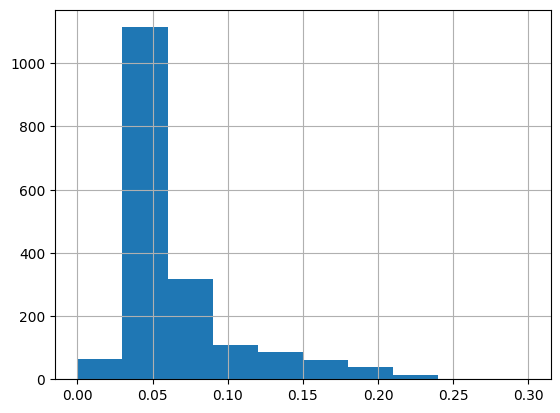

In [88]:
#HUE
df.mean_hue.hist(range=(0, 0.3))

<Axes: >

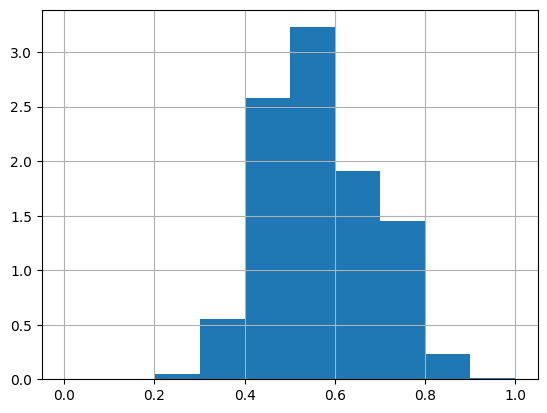

In [89]:
#SATURATION
df.mean_saturation.hist(range=(0, 1), density=True)

<Axes: >

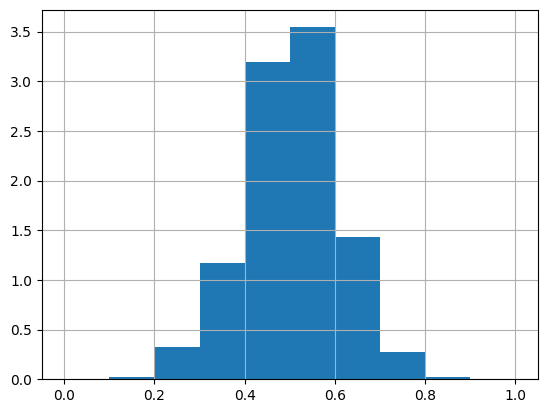

In [90]:
#VALUE / BRIGHTNESS
df.mean_value.hist(range=(0, 1), density=True)

<Axes: >

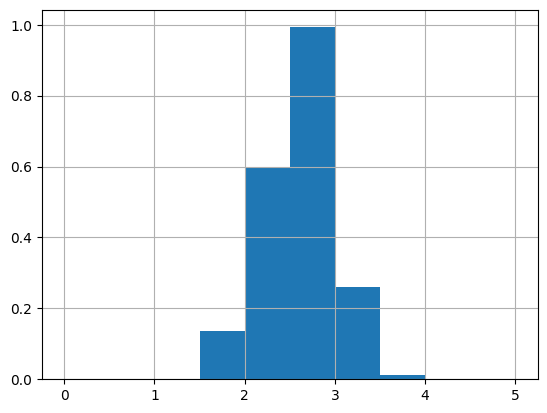

In [91]:
#ENTROPY
df.mean_entropy.hist(range=(0, 5), density=True)

# Yorumlar

### Hue değeri belli bir derece içinde yoğunlaşmış halde bulunmaktadır. Bu da verinin üstünde farklı baskın renkler olmadığını hepsinin birbirine benzer bir baskınlık içinde bulunduğunu gösterir.

### Saturation değeri yönelimli bir gaussian eğrisi çizmektedir. Verinin renk doygunluğu belli bir seviyenin üstündedir bu yüzden verimiz gri tonlarında değildir diyebiliriz.

### Value/Brightness histogramı içinde eşit olarak dağılmış diyebiliriz. Verimiz içinde ne çok karanlık ne de çok parlak imajlar bulunmamaktadır.

### Entropy histogramı bizim verimizin ne çok karışık ne de çok basit olduğunu göstermektedir